In [14]:
#  import libraries
import h5py
import os, sys
import zipfile
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt


# --- Configuration ---
from ICESEE.config._utility_imports import *

In [15]:
# Path to the ZIP file
# check if .zip file exists
# if not os.path.exists("results.zip"):
#     print("The file 'results.zip' does not exist.")
#     sys.exit()
    
# zip_file_path = "results.zip"
# # zip_file_path = "results_loc_joint.zip"
# output_folder = "results"

# # Unzip the file
# if os.path.exists(zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         # Create the output folder if it doesn't exist
#         if not os.path.exists(output_folder):
#             os.makedirs(output_folder)
#         zip_ref.extractall(output_folder)
#     print(f"Extracted '{zip_file_path}' to '{output_folder}'")
# else:
#     print(f"The file '{zip_file_path}' does not exist.")


In [16]:
results_dir = "results"
filter_type = "true-wrong"
# file_path = f"results/{filter_type}-icepack.h5"
file_path = f"{results_dir}/{filter_type}-icepack.h5"
datasets_tw = extract_datasets_from_h5(file_path)
t=datasets_tw['t']
# ensemble_true_state = datasets_tw['ensemble_true_state']
# ensemble_nurged_state = datasets_tw['ensemble_nurged_state']
# w = datasets_tw['w']
ind_m = datasets_tw['obs_index']
tm_m = datasets_tw['obs_max_time'][0]
run_mode = datasets_tw['run_mode'][0]

Reading data from results/true-wrong-icepack.h5...
Dataset 'Lxy' extracted with shape (2,)
Dataset 'b_io' extracted with shape (2,)
Dataset 'nxy' extracted with shape (2,)
Dataset 'obs_index' extracted with shape (10,)
Dataset 'obs_max_time' extracted with shape (1,)
Dataset 'run_mode' extracted with shape (1,)
Dataset 't' extracted with shape (201,)
Data extraction complete.


In [17]:
filter_type = "EnKF"
if run_mode != 0:
    file_path = f"{results_dir}/{filter_type}-icepack.h5"
    datasets = extract_datasets_from_h5(file_path)
    ensemble_vec_full = datasets["ensemble_vec_full"]
    ensemble_vec_mean = datasets["ensemble_vec_mean"] 
    ensemble_bg       = datasets["ensemble_bg"]
else:
    file_path = '_modelrun_datasets/icesee_ensemble_data.h5'
    import h5py
    with h5py.File(file_path, 'r') as f:
        ensemble_vec_full = f['ensemble'][:]
        ensemble_vec_mean = f['ensemble_mean'][:]
        # ensemble_true_state = f['true_state'][:]
        # ensemble_nurged_state = f['nurged_state'][:]
        ensemble_bg = None

In [18]:
with h5py.File('_modelrun_datasets/true_nurged_states.h5', 'r') as f:
    ensemble_true_state = f['true_state'][:]
    ensemble_nurged_state = f['nurged_state'][:]

with h5py.File('_modelrun_datasets/synthetic_obs.h5','r') as f:
    w = f['hu_obs'][:]
     # print(f["true_state"])

At h_indx = 100 profile 
(10,) (10,)


Text(0.5, 1.0, 'middle profile at h_indx = 100')

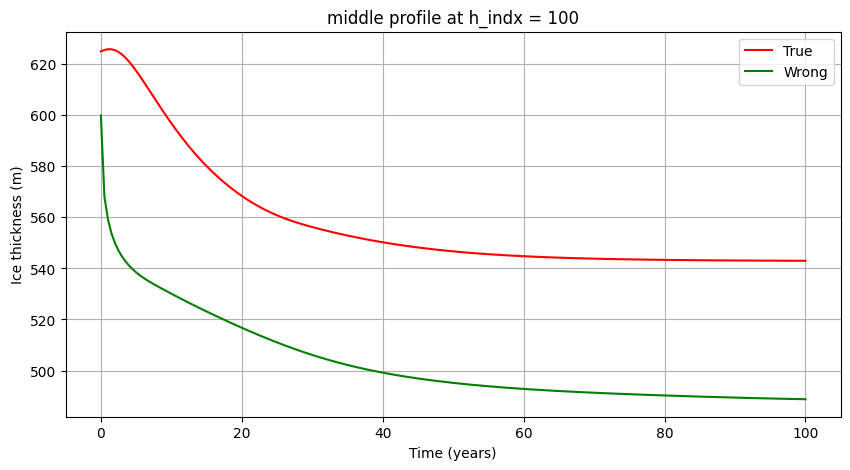

In [37]:


nt = ensemble_true_state.shape[1]; num_steps = nt-1
ndim = ensemble_true_state.shape[0]
hdim = ndim//4 # [h,u,v,smb]

# plot the ensemble_true_state and ensemble_nurged_state
htrue = ensemble_true_state[:hdim,:]
hnurge = ensemble_nurged_state[:hdim,:]

# define profile flag
profile_flag = "middle" # begining, middle, end, random
# h_indx = 0 # first profile
# h_indx = htrue.shape[1]//2 # middle profile
# h_indx = htrue.shape[1]-1 # last profile
# h_indx = np.random.randint(htrue.shape[1])  # random profile
if profile_flag == "begining":
    h_indx = 0 # first profile
elif profile_flag == "middle":
    h_indx = htrue.shape[1]//2
elif profile_flag == "end":
    h_indx = htrue.shape[1]-1
elif profile_flag == "random":
    h_indx = np.random.randint(htrue.shape[1])

print(f"At h_indx = {h_indx} profile ")

h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]

plt.figure(figsize=(10,5))
plt.plot(t,h_true,'r',label='True')
plt.plot(t,h_nurged,'g',label='Wrong')
obs = w[h_indx,:]; print(obs.shape,t[ind_m].shape)
# plt.plot(t[ind_m],obs,'kx',label="Observations")
plt.xlabel('Time (years)')
plt.ylabel('Ice thickness (m)')
plt.legend()
plt.grid()
plt.title(f"{profile_flag} profile at h_indx = {h_indx}")

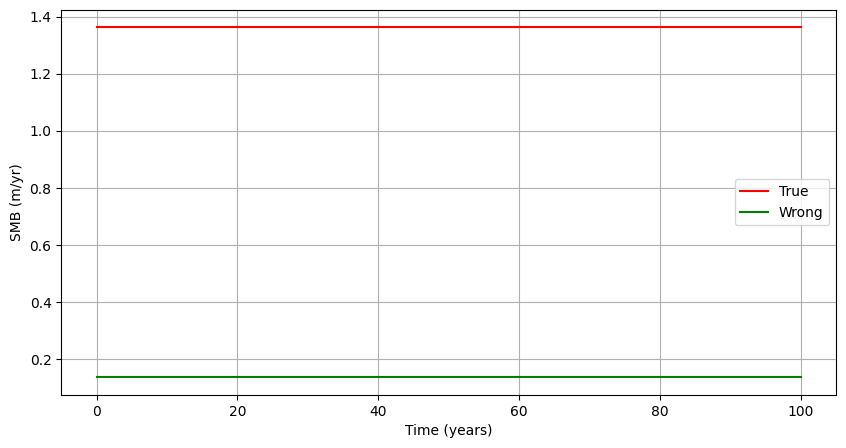

In [38]:
# extract smb
smbtrue = ensemble_true_state[3*hdim:,:]
smbnurged = ensemble_nurged_state[3*hdim:,:]

# plot the smbtrue
plt.figure(figsize=(10,5))
plt.plot(t,smbtrue[h_indx,:],'r',label='True')
plt.plot(t,smbnurged[h_indx,:],'g',label='Wrong')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.legend()
plt.grid()

In [21]:
from firedrake import *
import firedrake

Lx, Ly = datasets_tw["Lxy"][0], datasets_tw["Lxy"][1]
nx, ny = datasets_tw["nxy"][0], datasets_tw["nxy"][1]

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly,quadrilateral=True)
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
x, y = firedrake.SpatialCoordinate(mesh)
b_in, b_out = datasets_tw["b_io"][0], datasets_tw["b_io"][1]
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

a_in = firedrake.Constant(1.7)
δa = firedrake.Constant(-2.7)
a = firedrake.Function(Q).interpolate(a_in + δa * x / Lx)

# form a rectangular mesh and get x, y coordinates
x, y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
print(nx, ny, Lx, Ly,b_in, b_out)

12 8 5000 1200 200.0 -400.0


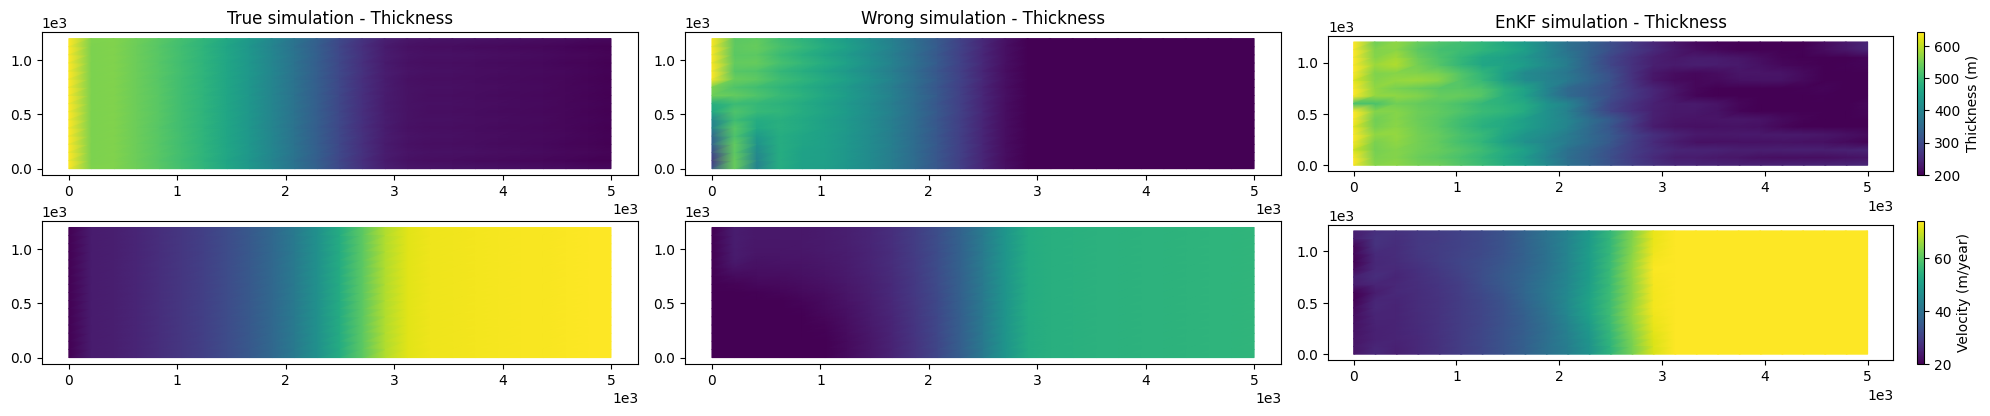

In [35]:
from firedrake import div
import copy
import icepack
import icepack.plot
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x3 subplot grid for 3 simulations (True, Wrong, EnKF), with thickness and velocity
fig, axes = icepack.plot.subplots(2, 3, figsize=(20, 4))

step = nt - 1

# Compute min/max for thickness and velocity to set consistent colorbar ranges
hhtrue = firedrake.Function(Q)
hhnurge = firedrake.Function(Q)
hhenkf = firedrake.Function(Q)
hhtrue.dat.data[:] = copy.deepcopy(ensemble_true_state[:hdim, step])
hhnurge.dat.data[:] = copy.deepcopy(ensemble_nurged_state[:hdim, step])
hhenkf.dat.data[:] = copy.deepcopy(ensemble_vec_mean[:hdim, step])
h_min = hhtrue.dat.data.min()
h_max = hhtrue.dat.data.max()

uutrue = firedrake.Function(V)
uunurge = firedrake.Function(V)
uuenkf = firedrake.Function(V)
uutrue.dat.data[:, 0] = copy.deepcopy(ensemble_true_state[hdim:2*hdim, step])
uutrue.dat.data[:, 1] = copy.deepcopy(ensemble_true_state[2*hdim:3*hdim, step])
uunurge.dat.data[:, 0] = copy.deepcopy(ensemble_nurged_state[hdim:2*hdim, step])
uunurge.dat.data[:, 1] = copy.deepcopy(ensemble_nurged_state[2*hdim:3*hdim, step])
uuenkf.dat.data[:, 0] = copy.deepcopy(ensemble_vec_mean[hdim:2*hdim, step])
uuenkf.dat.data[:, 1] = copy.deepcopy(ensemble_vec_mean[2*hdim:3*hdim, step])
# Compute magnitude of velocity for consistent scaling
u_true_mag = np.sqrt(uutrue.dat.data[:, 0]**2 + uutrue.dat.data[:, 1]**2)
u_nurge_mag = np.sqrt(uunurge.dat.data[:, 0]**2 + uunurge.dat.data[:, 1]**2)
u_enkf_mag = np.sqrt(uuenkf.dat.data[:, 0]**2 + uunurge.dat.data[:, 1]**2)
u_min = u_true_mag.min()
u_max = u_true_mag.max()

# True simulation - Thickness
colors = firedrake.tripcolor(hhtrue, axes=axes[0][0], vmin=h_min, vmax=h_max)
# fig.colorbar(colors, ax=axes[0][0], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][0].set_title("True simulation - Thickness")

# True simulation - Velocity
colors = firedrake.tripcolor(uutrue, axes=axes[1][0], vmin=u_min, vmax=u_max)
# fig.colorbar(colors, ax=axes[1][0], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# Wrong simulation - Thickness
colors = firedrake.tripcolor(hhnurge, axes=axes[0][1], vmin=h_min, vmax=h_max)
# fig.colorbar(colors, ax=axes[0][1], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][1].set_title("Wrong simulation - Thickness")

# Wrong simulation - Velocity
colors = firedrake.tripcolor(uunurge, axes=axes[1][1], vmin=u_min, vmax=u_max)
# fig.colorbar(colors, ax=axes[1][1], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# EnKF simulation - Thickness
colors = firedrake.tripcolor(hhenkf, axes=axes[0][2],  vmin=h_min, vmax=h_max)
fig.colorbar(colors, ax=axes[0][2], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][2].set_title("EnKF simulation - Thickness")

# EnKF simulation - Velocity
colors = firedrake.tripcolor(uuenkf, axes=axes[1][2], vmin=u_min, vmax=u_max)
fig.colorbar(colors, ax=axes[1][2], fraction=0.012, pad=0.04, label="Velocity (m/year)")

plt.tight_layout()

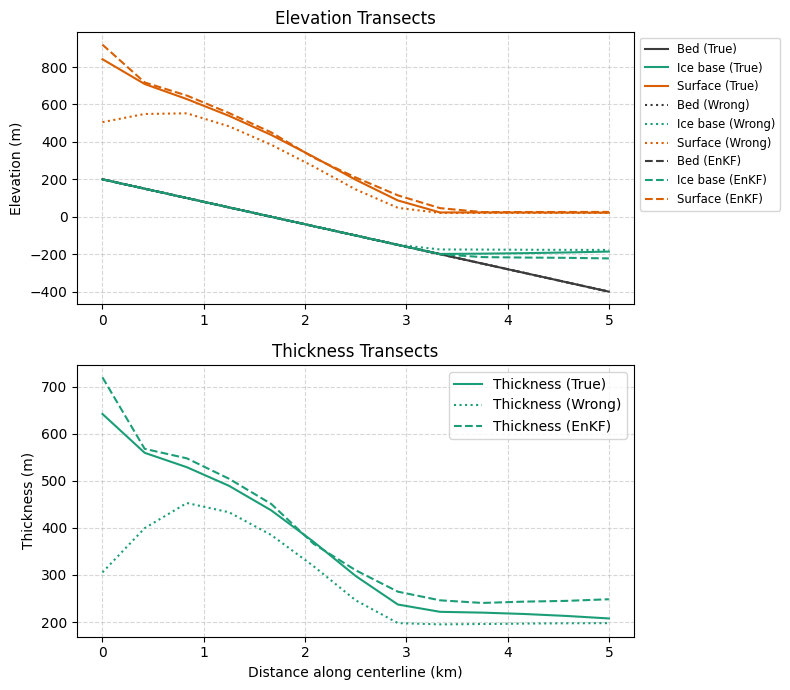

In [41]:
from firedrake import div
import copy
import icepack
import icepack.plot
import matplotlib.pyplot as plt
import numpy as np

# Define transect points
xs = np.array([(Lx * k / nx, 0) for k in range(nx + 1)])

# True simulation data
s_true = icepack.compute_surface(thickness=hhtrue, bed=b)
ss_true = np.array(s_true.at(xs, tolerance=1e-10))
bs_true = np.array(b.at(xs, tolerance=1e-10))
hs_true = np.array(hhtrue.at(xs, tolerance=1e-10))

# Wrong simulation data
s_nurge = icepack.compute_surface(thickness=hhnurge, bed=b)
ss_nurge = np.array(s_nurge.at(xs, tolerance=1e-10))
bs_nurge = np.array(b.at(xs, tolerance=1e-10))
hs_nurge = np.array(hhnurge.at(xs, tolerance=1e-10))

# EnKF simulation data
s_enkf = icepack.compute_surface(thickness=hhenkf, bed=b)
ss_enkf = np.array(s_enkf.at(xs, tolerance=1e-10))
bs_enkf = np.array(b.at(xs, tolerance=1e-10))
hs_enkf = np.array(hhenkf.at(xs, tolerance=1e-10))

# Create a 2x1 subplot layout
fig, axes = plt.subplots(2, 1, figsize=(8, 7))

# Define publication-quality colors
color_bed = '#3C3C3C'  # Dark gray for bed
color_ice_base = '#1B9E77'  # Deep teal for ice base and thickness
color_surface = '#D95F02'  # Warm red for surface

# Elevation plot (True, Wrong, and EnKF combined)
axes[0].plot(xs[:, 0] / 1e3, bs_true, color=color_bed, linestyle="-", label="Bed (True)")
axes[0].plot(xs[:, 0] / 1e3, ss_true - hs_true, color=color_ice_base, linestyle="-", label="Ice base (True)")
axes[0].plot(xs[:, 0] / 1e3, ss_true, color=color_surface, linestyle="-", label="Surface (True)")
axes[0].plot(xs[:, 0] / 1e3, bs_nurge, color=color_bed, linestyle=":", label="Bed (Wrong)")
axes[0].plot(xs[:, 0] / 1e3, ss_nurge - hs_nurge, color=color_ice_base, linestyle=":", label="Ice base (Wrong)")
axes[0].plot(xs[:, 0] / 1e3, ss_nurge, color=color_surface, linestyle=":", label="Surface (Wrong)")
axes[0].plot(xs[:, 0] / 1e3, bs_enkf, color=color_bed, linestyle="--", label="Bed (EnKF)")
axes[0].plot(xs[:, 0] / 1e3, ss_enkf - hs_enkf, color=color_ice_base, linestyle="--", label="Ice base (EnKF)")
axes[0].plot(xs[:, 0] / 1e3, ss_enkf, color=color_surface, linestyle="--", label="Surface (EnKF)")
axes[0].set_ylabel("Elevation (m)")
axes[0].set_title("Elevation Transects")
# axes[0].legend()
# Put legend outside the plot
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
axes[0].grid(True, linestyle='--', alpha=0.5)  # Add grid

# Thickness plot (True, Wrong, and EnKF combined)
axes[1].plot(xs[:, 0] / 1e3, hs_true, color=color_ice_base, linestyle="-", label="Thickness (True)")
axes[1].plot(xs[:, 0] / 1e3, hs_nurge, color=color_ice_base, linestyle=":", label="Thickness (Wrong)")
axes[1].plot(xs[:, 0] / 1e3, hs_enkf, color=color_ice_base, linestyle="--", label="Thickness (EnKF)")
axes[1].set_xlabel("Distance along centerline (km)")
axes[1].set_ylabel("Thickness (m)")
axes[1].set_title("Thickness Transects")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)  # Add grid

plt.tight_layout()

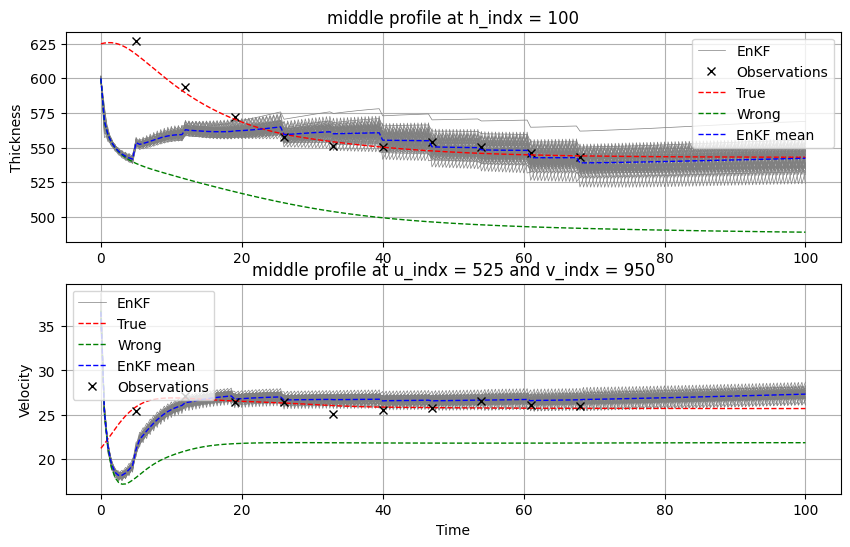

In [25]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

# h_obs = utils_funs.Obs_fun(hu_obs[:hdim,:])
obs_h = w[h_indx,:]


# plot the h middle profile
# h_indx = hens.shape[1]//2
hens = ensemble_vec_mean[:hdim,:]
h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]
h_ens_mean = hens[h_indx,:]
h_ens_mem  = ensemble_vec_full[h_indx,:,:].T
# h_ob = h_ob[-1,:]
Nens = ensemble_vec_full.shape[1]
for ens in range(Nens):
    ax[0].plot(t,h_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

# ax[0].plot(ts,h_ens_mem[:,:], lw=0.5, color='k',label="DEnKF ens")
ax[0].plot(t[ind_m],obs_h,'kx',label="Observations")

ax[0].plot(t,h_true,'--r',label='True',linewidth=1)
ax[0].plot(t,h_nurged,'--g',label='Wrong',linewidth=1)
ax[0].plot(t,h_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
# ax[0].plot(t[ind_m],hu_ob[1,:],'kx',label='Observations')
ax[0].legend()
# ax[0].set_ylim([350, 500])
# ax[0].set_xlim([1, 250])
# ax[0].set_xlabel('Time')
ax[0].grid()
ax[0].set_ylabel('Thickness')
ax[0].set_title(f"{profile_flag} profile at h_indx = {h_indx}")

# plot the u middle profile
# u_ob = utils_funs.Obs_fun(hu_obs[hdim:2*hdim,:])
# v_ob = utils_funs.Obs_fun(hu_obs[2*hdim:,:])
# uobs = np.sqrt(u_ob**2 + v_ob**2)
u_indx = hdim + h_indx
v_indx = 2*hdim + h_indx
obs_u = w[u_indx,:]
obs_v = w[v_indx,:]
uobs = np.sqrt(obs_u**2 + obs_v**2)
u_true = ensemble_true_state[u_indx,:]
v_true = ensemble_true_state[v_indx,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_nurge = ensemble_nurged_state[u_indx,:]
v_nurge = ensemble_nurged_state[v_indx,:]
unurge = np.sqrt(u_nurge**2 + v_nurge**2)
u_ens_mean = ensemble_vec_mean[u_indx,:]
v_ens_mean = ensemble_vec_mean[v_indx,:]
uens_mean = np.sqrt(u_ens_mean**2 + v_ens_mean**2)
u_ens_mem  = ensemble_vec_full[u_indx,:,:].T
v_ens_mem  = ensemble_vec_full[v_indx,:,:].T
uens_mem = np.sqrt(u_ens_mem**2 + v_ens_mem**2)
for ens in range(Nens):
    ax[1].plot(t,uens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

ax[1].plot(t,utrue,'--r',label='True',linewidth=1)
ax[1].plot(t,unurge,'--g',label='Wrong',linewidth=1)
ax[1].plot(t,uens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
ax[1].plot(t[ind_m],uobs,'kx',label='Observations')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].grid()
ax[1].set_title(f"{profile_flag} profile at u_indx = {u_indx} and v_indx = {v_indx}")
# save the figure
plt.savefig(f"{results_dir}/{filter_type}_profile_{profile_flag}_s.png")


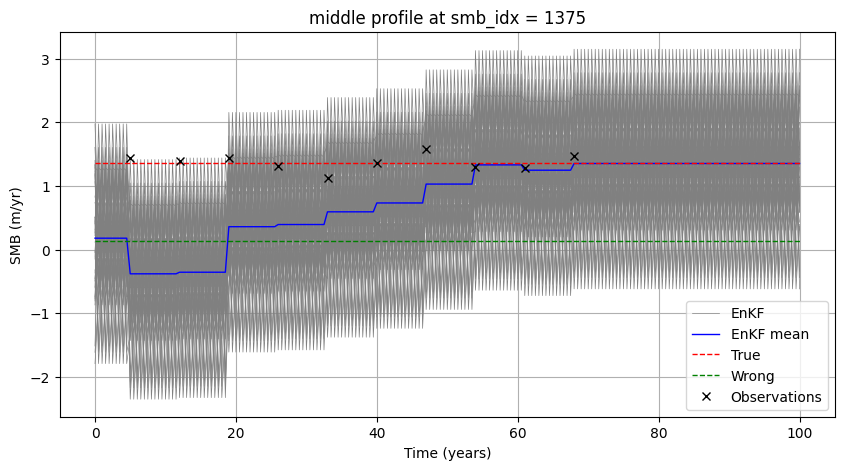

In [26]:
# plot the smb middle profile
smb_idx = 3*hdim + h_indx
smbtrue = ensemble_true_state[smb_idx,:]
smb_nurged = ensemble_nurged_state[smb_idx,:]
smbs_ens_mean = ensemble_vec_mean[smb_idx,:]
smb_ens = ensemble_vec_full[smb_idx,:,:].T
smb_obs = w[smb_idx,:]
plt.figure(figsize=(10,5))
for ens in range(Nens):
    plt.plot(t,smb_ens[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")
plt.plot(t,smbs_ens_mean,'-b',label=f"{filter_type} mean",linewidth=1)
plt.plot(t,smbtrue,'--r',label='True',linewidth=1)
plt.plot(t,smb_nurged,'--g',label='Wrong',linewidth=1)
plt.plot(t[ind_m],smb_obs,'kx',label='Observations')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.title(f"{profile_flag} profile at smb_idx = {smb_idx}")
plt.grid()
plt.legend()
